### HHW Lab 2 : GNSS analysis
In this notebook, you'll work through the post-processing steps of GNSS data analysis.

Goals for this notebook:
* Understand the different products available
* Work with GNSS vertical time series
* Evaluate the differences between different GPS stations
* Work through some of the common steps to remove non-hydrologic signals from vertical GNSS timeseries
* Fit an annual model to the signal 
* Remove outliers from the time series 

### Part I : Processed data


For this notebook, you'll be utilizing time series downloaded from the Nevada Geodetic Lab (http://geodesy.unr.edu/) which provides processed GNSS time series. In the previous lectures, we've discussed broadly how GNSS data is processed. Every analysis center processes their data slightly differently and locating the processing strategy documents is important. I would like you to spend a few minutes on the NGL website and find their processing document which explains all the different steps and corrections that are made to the GNSS time series. (Hint: check that right hand panel).

**Q1: Please link the processing strategy document here:**

 http://geodesy.unr.edu/gps/ngl.acn.txt

**Q1.2: In the processing strategy document, what software is used to produce the NGL time series?**

GIPSY

If you're interested in exploring more about the different processing softwares and how they work I highly recommend checking out the websites associated with the different softwares or taking a short course from the groups that maintain and write the programs. In science the most common softwares used are GIPSY and GAMIT, which are also both open source. Some groups also use Bernese, especially European based group, however it is not open source. 

GIPSY link : https://gipsy-oasis.jpl.nasa.gov/

GAMIT link : http://geoweb.mit.edu/gg/ under the workshop tab, unavco also has all their old materials from past workshops. 

UNAVCO has also provided this link which gives the basics in terms of the different softwares: https://www.unavco.org/software/data-processing/postprocessing/postprocessing.html

**Q1.3: You'll see under measurement models, in the processing document, that many different models are corrected for. What ocean tide loading model is used?**

FES2004 -- note this tide model is from 2004! Most analysis centers use this tide model. 

**Q1.4: Is non-tidal atmospheric loading corrected for? What about non-tidal ocean bottom pressure?**

NTAL is not corrected for, nor is NTOL. Good thing we correct for it later. 

Processing GNSS time series is no small task and proper citation of the analysis center data is crucial whenever using GNSS data. 

**Q2: Please find the preferred citation for the NGL time series and link it here:**


Blewitt, G., W. C. Hammond, and C. Kreemer (2018), Harnessing the GPS data explosion for interdisciplinary science, Eos, 99,
https://doi.org/10.1029/2018EO104623.

NGL provides multiple different solutions. The first two categorizations are based on the sample rate and the latency (the delay before a transfer of data begins following an instruction for its transfer - aka how long till a data product is available after the data is collected). NGL provides 24 hour sample rate solutions and 5 minute sample rate solutions at different latencies. 

**Q3: 
A final orbit solution has what latency:** 2 weeks

**A rapid orbit solution has what latency:** 24 hours

**An ultra rapid solution has what latency:** 1.5 hours



Like the name suggests these different solutions have different latencies based on the satellite orbit solution that is being used for the processing. The reason for this is that the orbits are corrected and then all the data is reprocessed with the "final" solution. However, sometimes rapid solutions are needed -- such as after a large earthquake. We will be using the 24 hour final orbit solutions.


NGL additionally provides solutions in multiple different reference frames. Reference frames can be a bit of a rabbit hole -- one that many geodesists venture down. For now, you can think of a reference frame as a point of view. It's indicating how that station is moving relative to a defined point. In the US, the two primary ones are the IGS14 and NA (North American fixed). 

NA fixed reference frame means that its setting a point in the north american tectonic plate as "stable" and rigid which means all motion is relative to that stable point. Most tectonic plates have a reference frame. These reference frames are really useful in tectonic studies becuase you can explore how one plane is moving relative to another.  

IGS14 - is the international GNSS serivce 2014 realization of the International Terrestial Reference Frame 2014 (ITRF14) (older versions are typically labeled based on the year they are created - thus an IGS08 was created in 2008). This is a global reference frame and thus is not tied to any specific tectonic plate. Instead is uses positions from points around the world that are relatively stable (think long time series that are not overly influenced by tides or tectonics) and combines data from GNSS stations and other geodetic measurement systems. 

If you want more information about the IGS reference frame you can nerd out here: https://academic.oup.com/gji/article/209/3/1906/3095992 


Other helpful links for reference frames: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014GC005407 or https://www.unavco.org/software/visualization/GPS-Velocity-Viewer/GPS-Velocity-Viewer-frames.html or http://www.nbmg.unr.edu/staff/pdfs/Blewitt_Encyclopedia_of_Geodesy.html

**Q4: Navigate to the map view of stations and click open a station near the west coast of the US. In addition to the IGS and NA reference frames, what reference frame is provided? What tectonic plate is this in reference to?**


PA - Pacific plate fixed

We will be using IGS14 solutions. This is a typical choice in hydrogeodesy since we aren't necessarily interested in how one plate is moving relative to another. 

NGL also helpfully provides a list of potential offsets or steps in the time series. Please remember these are *potential* steps. 

**Q5: Please link the step file here:**


http://geodesy.unr.edu/NGLStationPages/steps.txt

NGL also seperates the stepfile into two different step type codes.

**Q6: Code1 is:**

Equipment changes

**Q8: Give an example of a type of Code 1:**

Antenna change, reciever change, elevation mask change ect

**Q7: Code2 is:**

Earthquakes

**Q9: What is information is used in Code2:**

It's a distance-magnitude relationship. It's further explained in this document: http://geodesy.unr.edu/NGLStationPages/steps_readme.txt

**Q10: As if you're writing a paper using this data, please write a sentence describing the GNSS data:**

We are using UNR NGL time series which are processed in GIPSY in the IGS2014 reference frame (Blewitt et al., 2018).

### Part II : Initial time series

While these first questions and background information may seem a little odd, I want you all to get an understanding of all the different products available so that you can understand what other scientists are using but also so that you can hopefully come back later and find the product you want to use for a specific application. 


Now, that you have some familiarity with the website and the documentation associated with the NGL time series, let's get to work on the actual time series. In the GNSS notebook folder you'll find the time series for multiple GNSS stations. Please import the data (using pandas, please) from CRCN and P571. They are located in the GNSS_data folder so you'll have to include that in the path for importing. Please label the dataframes crcn and p571 and format the date into a datetime object. The units of the position and standard deviations are in mm.

**Special thanks to Lucky Sandoe for providing her code that were used to help to make this key**

In [1]:
##Import the libraries you'll likely need
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

crcn = pd.read_csv("GNSS_data/CRCN_UNR.txt", sep=',').dropna().reset_index(drop=True)
p571 = pd.read_csv("GNSS_data/P571_UNR.txt", sep=',').dropna().reset_index(drop=True)
crcn['Date'] = pd.to_datetime(crcn['Date'])
p571['Date'] = pd.to_datetime(p571['Date'])

crcn = crcn.set_index('Date')
p571 = p571.set_index('Date')


Cut both  time series to 1 October 2010 to 1 October 2019 and plot the vertical time series 
I recommend plotting them on separate figures -- remember the command %matplotlib notebook above the plot
will allow for an interactive plot which will be helpful for the following questions. I personally enjoy plotting 
the GNSS time series as a scatter plot which you can do by assigning the marker in the plot command. Just add '.' and
it will plot it as points - the default is lines. I find this easier to diagnose the time series later but it is totally up to you.

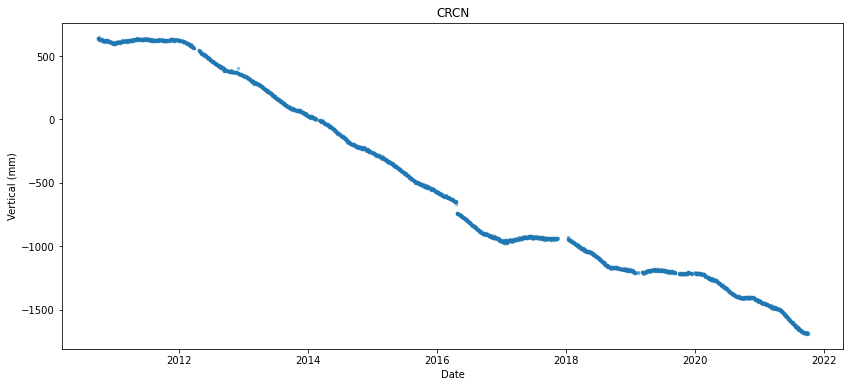

In [2]:
##This is what you'll cut your time series to, GNSS and hydrologic
startdate = pd.to_datetime('10/1/2008', format = '%m/%d/%Y')
enddate = pd.to_datetime('9/29/2021', format = '%m/%d/%Y')

crcn = crcn[startdate:enddate]
p571 = p571[startdate:enddate]

%matplotlib inline
fig, ax = plt.subplots(figsize=(14, 6),sharex=True, sharey=True)
ax.scatter(crcn.index, crcn['vertical'], alpha=0.4, s=6)
ax.set_xlabel('Date')
ax.set_ylabel('Vertical (mm)')
ax.set_title('CRCN');


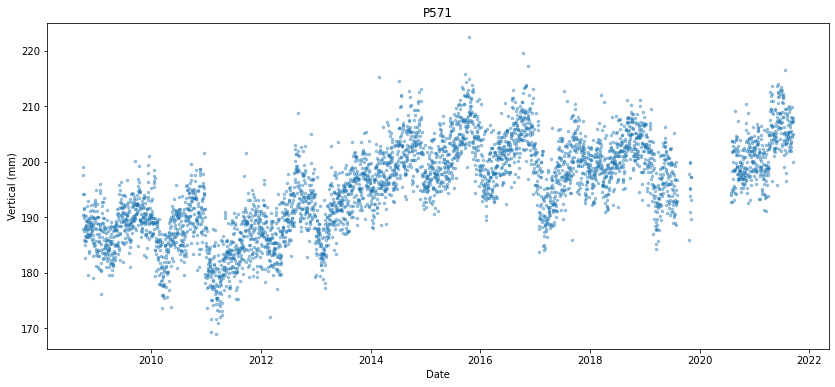

In [3]:
fig, ax = plt.subplots(figsize=(14, 6),sharex=True, sharey=True)
ax.scatter(p571.index, p571['vertical'], alpha=0.4, s=6)
ax.set_xlabel('Date')
ax.set_ylabel('Vertical (mm)')
ax.set_title('P571');

**Q10: Please describe the vertical time series of CRCN. Is there anything anomalous in the time series (eg features you might want to remove or be aware of)?**

There is a strong linear trend with some seasonality in it. There are offsets in the time series. There also seems to be some outliers in the data. Since UNR does not remove NTAL and NTOL we'll want to remove that as well. Also there are some gaps that we should be aware of. 

**Q11: Please describe the vertical time series of P571. Is there anything anomalous in the time series (eg features you might want to remove or be aware of)?**

There look like there are outliers in the data. There is a strong seasonal signal and a slight linear trend. 

**Q12: Why do you think these time series look different?**

**Q13: Do you think these two stations are near each other? Ok, now go ahead and look up where these stations are located using the NGL website. Where are the stations located?**

The stations are near each other. One is in the Central Valley and the other is in the Sierra Nevada Mountains. 

**Q14: Does that change your station to Q12? If yes, any new guesses. Feel free to talk to your neighbors.**

One is dominated by the compaction of the aquifer in the Central Valley (CRCN) and thus measuring the poroelastic effects and the other is measuring elastic loading in the Sierra Nevada Mountains (P571). This pumping of water out of the aquifer in the central valley causes the aquifer pores to collapse and for extreme subsidence to occur. This is the domiant signal being measured. p571 is located in bedrock and does not feel this aquifer compaction. 

### Part III : Removing non-hydrologic signals

Now, let's start removing some signals from the time series. We'll start by removing some known signals from the time series. Non-tidal atmospheric loading (NTAL) and non-tidal oceanic loading (NTOL) signals are commonly removed to isolate the hydrologic signal in GNSS time series. 

We'll be utilizing the ESMGFZ products (http://esmdata.gfz-potsdam.de:8080/repository/entry/show/Home?entryid=e0fff81f-dcae-469e-8e0a-eb10caf2975b&output=default.html). These are the predicted crustal displacements due to non-tidal atmospheric surface pressure (NTAL) or non-tidal ocean bottom pressure (NTOL). GFZ provides publicly available global grids at sub-daily resolution. If you want more information on how the grids are made check out Dill and Dobslaw, 2013 (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/jgrb.50353) or the ESMGFZ website linked above. 

More reading on NTAL and NTOL for those interested: https://link.springer.com/article/10.1007/s10291-021-01135-w and https://link.springer.com/article/10.1007/s00190-020-01445-w

The readme files provided by GFZ are really excellent and make using their data easy. However, to save time I've already downloaded the necessary files for the GNSS stations we're using and resampled them to be daily resolution. Go ahead and import them from the group share and then plot them. They are in **meters. Make sure to convert them to mm!**


In [4]:
ntol_c = pd.read_csv("GNSS_data/NTOL21.CRCN.txt")
ntol_p = pd.read_csv("GNSS_data/NTOL21.P571.txt")

ntal_c = pd.read_csv("GNSS_data/NTAL21.CRCN.txt")
ntal_p = pd.read_csv("GNSS_data/NTAL21.P571.txt")

#Only dealing with the vertical so only going to convert that
ntol_c['vertical1']=ntol_c['vertical']*1000
ntol_c['Date1']=pd.to_datetime(ntol_c['Date'])
ntol_p['vertical1']=ntol_p['vertical']*1000
ntol_p['Date1']=pd.to_datetime(ntol_p['Date'])
ntal_c['vertical2']=ntal_c['vertical']*1000
ntal_c['Date2']=pd.to_datetime(ntal_c['Date'])
ntal_p['vertical2']=ntal_p['vertical']*1000
ntal_p['Date2']=pd.to_datetime(ntal_p['Date'])


**Q15: Describe the NTAL and NTOL signals? Similarities? Differences?** 

The NTAL has a much larger amplitude and a stronger seasonal signal. Since this signal is similar timing to hydrologic signals its very important to remember to remove. 

Since these are elastic displacements, they are additive. The earth is measuring the sum of all the loading signals so we can add the NTOL and NTAL together and then remove it from the GNSS time series. Go ahead and do that now. 

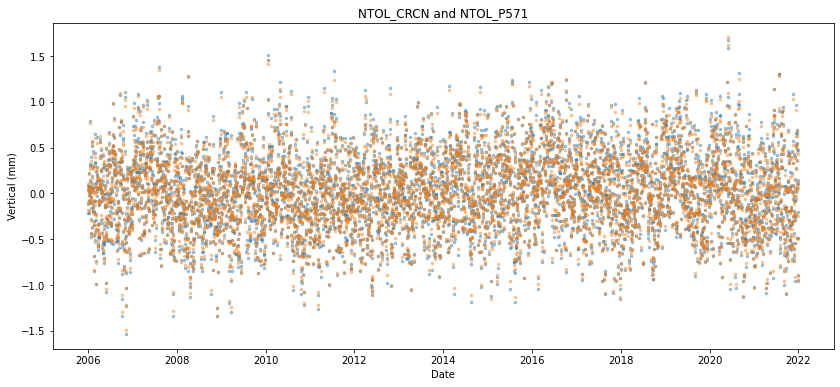

In [5]:
fig, ax = plt.subplots(figsize=(14, 6),sharex=True, sharey=True)
ax.scatter(ntol_c['Date1'], ntol_c['vertical1'], alpha=0.4, s=6)
ax.scatter(ntol_p['Date1'], ntol_p['vertical1'], alpha=0.4, s=6)
ax.set_xlabel('Date')
ax.set_ylabel('Vertical (mm)')
ax.set_title('NTOL_CRCN and NTOL_P571');

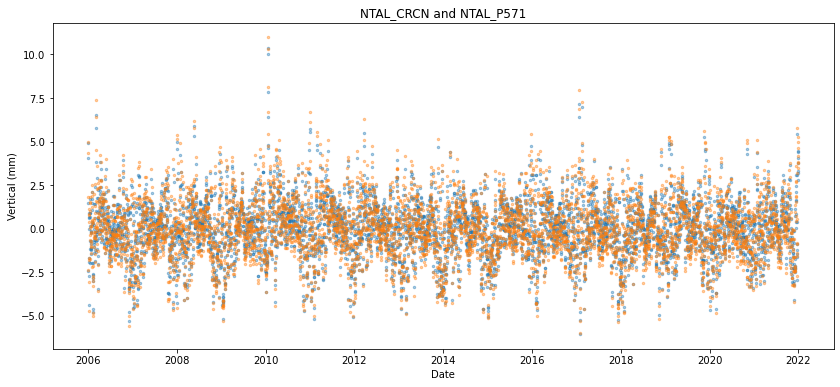

In [6]:
fig, ax = plt.subplots(figsize=(14, 6),sharex=True, sharey=True)
# ax.scatter(ntol_c['Date'], ntol_c['vertical'], alpha=0.4, s=6)
# ax.scatter(ntol_p['Date'], ntol_p['vertical'], alpha=0.4, s=6)
ax.scatter(ntal_c['Date2'], ntal_c['vertical2'], alpha=0.4, s=6)
ax.scatter(ntal_p['Date2'], ntal_p['vertical2'], alpha=0.4, s=6)
ax.set_xlabel('Date')
ax.set_ylabel('Vertical (mm)')
ax.set_title('NTAL_CRCN and NTAL_P571');

In [7]:
p571_atmo = pd.concat([ntal_p, ntol_p], axis = 1) #combining the dataframes together
crcn_atmo = pd.concat([ntal_c, ntol_c], axis = 1)

p571_atmo['combined'] = p571_atmo.vertical2 + p571_atmo.vertical1 #adding the NTAL and NTOL together
crcn_atmo['combined'] = crcn_atmo.vertical2 + crcn_atmo.vertical1

#Set the index to be date -- some funkiness because of having multiple date columns but want it to be called Date
p571_atmo = p571_atmo.set_index('Date1')
crcn_atmo = crcn_atmo.set_index('Date1')
p571_atmo.index = p571_atmo.index.rename('Date')
crcn_atmo.index = crcn_atmo.index.rename('Date')

In [8]:
p571['atmo']= p571_atmo.combined ##tack on the atmospheric loading to the GNSS dataframe
crcn['atmo']= crcn_atmo.combined


p571['vertical']= p571.vertical - p571.atmo ##remove it from the vertical
crcn['vertical']= crcn.vertical - crcn.atmo

Next, we'll fit the linear trend using a built in python function or by writing your own. A common python function to do this is polyfit (example here: https://www.adamsmith.haus/python/answers/how-to-plot-a-line-of-best-fit-in-python). Just fyi, polyfit does not like NaNs. A good function to remove NaNs from a pandas time series is using df = df.dropna(). 

If you, like me, have set the Date as the index the polyfit function will not work since it does not like dealing with datetime data types. A trick to getting around this while maintaining all the good date information (such as gaps) is by using the datetime function *tooordinal*. Here's an example: https://www.geeksforgeeks.org/python-datetime-toordinal-method-with-example/ But to make it easy on you, here's how I do it. I assign a new column named 't' here (or whatever you like) to be the ordinal. This will convert my dates to a number that can also be mapped back to a date if needed. However, by assigning it to a new column I'll keep the date index so no need for mapping back to a date.  
*df['t']=df.index.map(dt.datetime.toordinal)*

HOWEVER, please rename this linear trend signal something new (eg a new column in the data frame). We'll work with the NTAL and NTOL removed signal again in the next step. Here's one way to do this 

As with everything in python, there are many ways to do the same thing. This is just one option so if you have a different method - go for it! In fact, let me know how you do it. I love learning alternative ways to do things in python. 

When writing new code, I recommend checking the data at each step to make sure its doing what you think it is. It seems time consuming but catching a bug early will save you more time in the long run. Go ahead and plot the linear trend and the vertical data. If it doesn't look right, check your code. 


In [9]:
crcn = crcn.dropna()
crcn['t'] = crcn.index.map(dt.datetime.toordinal)
m, b = np.polyfit(crcn.t, crcn.vertical, 1)
lin1 = m*crcn.t + b
print(m)
p571 = p571.dropna()
p571['t'] = p571.index.map(dt.datetime.toordinal)
m1, b1 = np.polyfit(p571.t, p571.vertical, 1)
lin2 = m1*p571.t + b1
print(m1)

-0.6177110658586515
0.004208725754274375


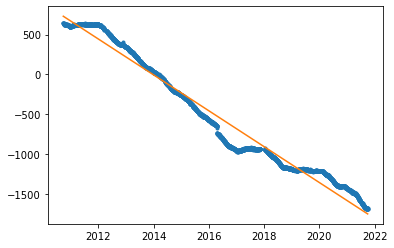

In [10]:
plt.plot(crcn.vertical, '.')
plt.plot(lin1)

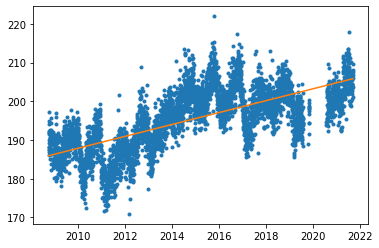

In [11]:
plt.plot(p571.vertical, '.')
plt.plot(lin2)

**Q15: What is the rate of the linear trend in mm/yr for CRCN and for P571?**

Printed above for CRCN and then P571.

**Q16: For CRCN, what do you think the dominate source of this signal is? Feel free to chat with your neighbors.**

The compaction of the aquifer. 

**Q17: For P571, what do you think the dominate source of this signal is? Feel free to chat with your neighbors.**

Tectonic uplift of the Sierra Nevada. 

**Q18: For P571 or CRCN, do you think this is the only source of the signal? Can you come up with any other sources that might exhibit similar patterns? Feel free to chat with your neighbors.**

There also might be some long term hydrlogic signal like drought that could look similar to a linear trend. 

Go ahead and remove the linear trend from the vertical time series. Again, make sure to keep the NTAL/NTOL removed signal as well. And plot the resulting signal. 

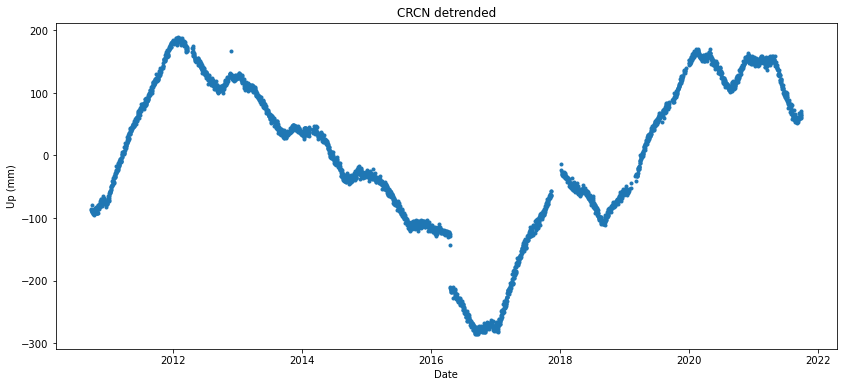

In [16]:
crcn['trem']  = crcn.vertical - lin1


fig, ax = plt.subplots(figsize=(14, 6),sharex=True, sharey=True)
ax.plot(crcn.trem, '.')
ax.set_xlabel('Date')
ax.set_ylabel('Up (mm)')
ax.set_title('CRCN detrended');

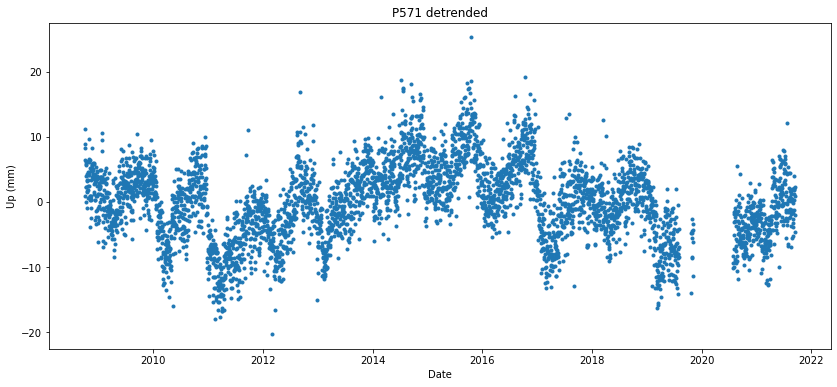

In [15]:
p571['trem']  = p571.vertical - lin2

fig, ax = plt.subplots(figsize=(14, 6),sharex=True, sharey=True)
ax.plot(p571.trem, '.')
ax.set_xlabel('Date')
ax.set_ylabel('Up (mm)')
ax.set_title('P571 detrended');

**Q19: Describe the resulting signals for CRCN and P571. Are there variations year to year?**

Next, we're going to investigate the seasonal signal. The seasonal signal is typically dominated by hydrologic loading. To estimate the signal we'll work with a portion of the GNSS equation. This will fit a linear trend and a harmonic signal. I've listed the equation below. Those of you who are cruising through this notebook, I highly encourage you to try and code this yourself. Give it a shot! If you get confused you can check out the function I have pre-written. 

We can describe the position of the GNSS vertical timeseries at a given time epoch as:


${y}(t_{i}) = {y}_{0} + {v}({t}_{i}) + {a}\sin(\omega{t}_{i}) + {b}\cos(\omega{t}_{i}) + {c}\sin(2\omega{t}_{i}) + {d}\cos(2\omega{t}_{i})$


Where ${y}_{0}$ is the position at time epoch 0. 

**Q20: And ${v}({t}_{i})$ represents the:**

The linear trend

The last portion of the equation describes the harmonic function. In this case we'll be fitting an annual and semi-annual signal to the time series. $ {a}\sin(\omega{t}_{i}) + {b}\cos(\omega{t}_{i})$ is the annual component, and ${c}\sin(2\omega{t}_{i}) + {d}\cos(2\omega{t}_{i})$ is the semi-annual component. $\omega$ is the period which for annual signals would be $2\pi/365.25$

For those of you using the pre-built function, we'll be solving this equation using least squares. It reads in a columns of a dataframe (eg gps.vertical), the omega, and an ordinal time column (see above if you didn't do it while fitting the linear trend), and a True or False if you want to fit the semi-annual in addition to the annual. It will return the model and the coefficients as an array. Go ahead and fit the model to the vertical component (NTAL and NTOL removed). Don't forget to define the omega. 

*y_v, m = harm_fit(pnum.vertical, omega, pnum.t, True)*

Then m is an array of the coefficients in the harmonic function. So m[0] is y_0 and m[1] is the v(t) and m[2] is a, and so on. 

In [17]:
from __future__ import division
import numpy as np

# Ingest 1 component of the timse seris, omega, time in ordinal 
def harm_fit(tseries, omega, dtime, semi):
    #Observations
    dv = np.array(tseries)
    if (semi == False): #just the annual
        #G matrix
        #Start with an empty matrix
        Gv = np.zeros((len(dv), 4))
        #Make the columns to be filled
        c1v = np.ones((len(dv)))
        c2v = np.array(dtime)
        c3v = np.sin(c2v*omega)
        c4v = np.cos(c2v*omega)
        #Fill the G matrix
        Gv[:,0] = c1v
        Gv[:,1] = c2v
        Gv[:,2] = c3v
        Gv[:,3] = c4v
        #Solve using Least Squares
        mv = np.linalg.solve(np.dot(np.transpose(Gv), Gv),np.dot(np.transpose(Gv),dv))
        m2 = mv.copy()
        # Full harmonic :
        y_v = mv[0] + mv[1]*dtime + mv[2]*np.sin(omega*dtime) + mv[3]*np.cos(omega*dtime)
    else: #annual + semi annual
        omega2 = 2*omega
        #G matrix
        #Start with an empty matrix
        G2 = np.zeros((len(dv), 6))
        #Make the columns to be filled
        c1 = np.ones((len(dv)))
        c2 = np.array(dtime)
        c3 = np.sin(c2*omega)
        c4 = np.cos(c2*omega)
        c5 = np.sin(c2*omega2)
        c6 = np.cos(c2*omega2)
        #Fill the G matrix
        G2[:,0] = c1
        G2[:,1] = c2
        G2[:,2] = c3
        G2[:,3] = c4
        G2[:,4] = c5
        G2[:,5] = c6
        #Solve using Least Squares
        m2 = np.linalg.solve(np.dot(np.transpose(G2), G2),np.dot(np.transpose(G2),dv))
        # Full harmonic :
        y_v = m2[0] + m2[1]*dtime + m2[2]*np.sin(omega*dtime) + m2[3]*np.cos(omega*dtime) + m2[4]*np.sin(omega2*dtime) +m2[5]*np.cos(omega2*dtime)
    return y_v, m2

In [18]:
yv_crcn, m2_crcn = harm_fit(crcn['vertical'], 2*np.pi/365.25, crcn['t'], True)
yv_p571, m2_p571 = harm_fit(p571['vertical'], 2*np.pi/365.25, p571['t'], True)

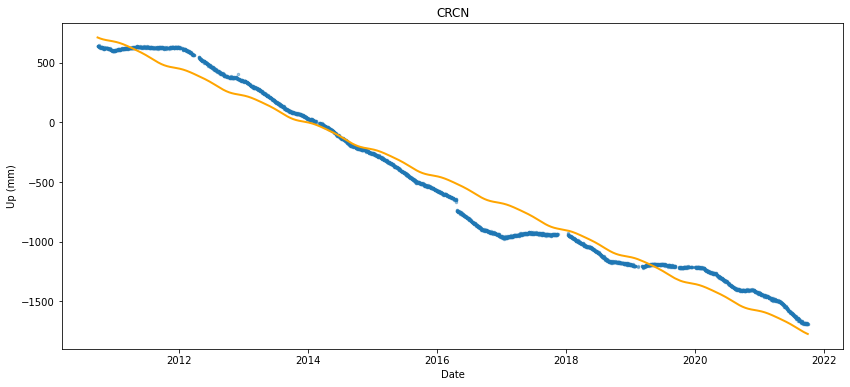

In [25]:
fig, ax = plt.subplots(figsize=(14, 6),sharex=True, sharey=True)
ax.scatter(crcn.index, crcn['vertical'], alpha=0.4, s=6)
ax.plot( yv_crcn, color='orange', linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Up (mm)')
ax.set_title('CRCN');

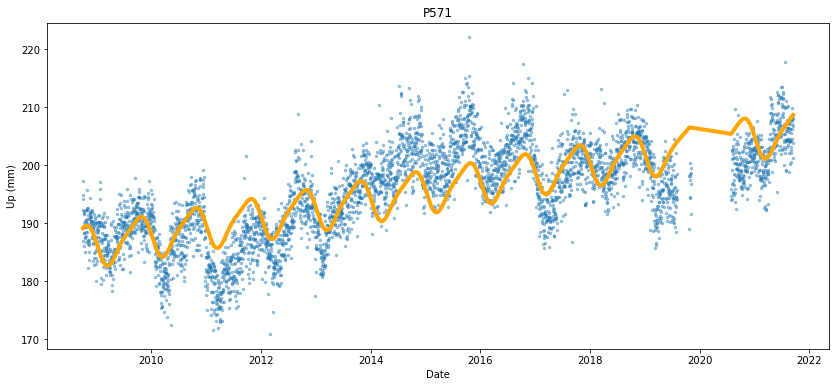

In [27]:
fig, ax = plt.subplots(figsize=(14, 6),sharex=True, sharey=True)
ax.scatter(p571.index, p571['vertical'], alpha=0.4, s=6)
ax.plot(yv_p571, color='orange', linewidth=4)
ax.set_xlabel('Date')
ax.set_ylabel('Up (mm)')
ax.set_title('P571');

Plot the vertical time series and the model on the same figure to make sure it looks good. 

**Q21: Looking at your plots of the model and the vertical time series. Does it fit the data perfectly? What is this model actually fitting, eg how are you going to interpret this model?**

They don't fit perfectly. This model is primarily fitting the seasonal signal so its really providing us information about the average amplitude and average timing of the seasonal signal. Key word here being average. 

Now, lets check out the coefficients. The first coefficient is the position at the start of this time series, the second it the linear trend, the third and fourth can be recombined to determine the annual amplitude and the fifth and sixth can be recombined to determine the semi-annual amplitude. The harmonic coefficients can be negative depending on when in the harmonic cycle the time series starts, so don't worry if they are negative. To determine the amplitude of the harmonic components you'll use the following equation $A = \sqrt{({a}^2 + {b}^2)}$ for the annual signal which means that 


Right, now let's calculate them. 

**Q22: What is the amplitude of the annual signal in P571? What about the semi-annual signal?**

In [42]:
print('The annual amplitude for CRCN is:'+str(np.sqrt(m2_crcn[2]**2+m2_crcn[3]**2)))
print('The annual amplitude for P571 is:'+str(np.sqrt(m2_p571[2]**2+m2_p571[3]**2)))

The annual amplitude for CRCN is:15.959650354983703
The annual amplitude for P571 is:3.5134764198886717


**Q24: What is the amplitude of the annual signal in CRCN? What about the semi-annual signal?**

In [43]:
print('The semi-annual amplitude for CRCN is:'+str(np.sqrt(m2_crcn[4]**2+m2_crcn[5]**2)))
print('The semi-annual amplitude for P571 is:'+str(np.sqrt(m2_p571[4]**2+m2_p571[5]**2)))

The semi-annual amplitude for CRCN is:3.3228344890723833
The semi-annual amplitude for P571 is:0.7655319848240653


Find the min or max of a signal can be done using a handy little function called argmin or argmax: https://numpy.org/doc/stable/reference/generated/numpy.argmax.html 

*variablename = np.argmax(y_v)* or same with argmin

Great, let's figure out when the max and min occurs in both time series.

In [111]:
#Just have the harmonic and not the linear + harmonic here
harm_p571 = np.sin(2*np.pi/365.25*p571.t)*m2_p571[2]+np.cos(2*np.pi/365.25*p571.t)*m2_p571[3]+np.sin(np.pi/365.25*p571.t)*m2_p571[4]+np.cos(np.pi/365.25*p571.t)*m2_p571[5]
harm_crcn = np.sin(2*np.pi/365.25*crcn.t)*m2_p571[2]+np.cos(2*np.pi/365.25*crcn.t)*m2_p571[3]+np.sin(np.pi/365.25*crcn.t)*m2_p571[4]+np.cos(np.pi/365.25*crcn.t)*m2_p571[5]


**Q: P571 reaches its max in what month? And its min?**

In [112]:
print('The min for P571 occurs in:'+str(harm_p571.index[np.argmin(harm_crcn)].month))
print('The min for CRCN occurs in:'+str(harm_crcn.index[np.argmin(harm_crcn)].month))

The min for P571 occurs in:7
The min for CRCN occurs in:4


**Q: CRCN reaches its max in what month? And its min?**

In [113]:
print('The max for P571 occurs in:'+str(harm_p571.index[np.argmax(harm_crcn)].month))
print('The max for CRCN occurs in:'+str(harm_crcn.index[np.argmax(harm_crcn)].month))


The max for P571 occurs in:7
The max for CRCN occurs in:9


**Q: Say you were interested in looking at elastic loading across the whole western US or some large area, how might this information be useful?**

As you add water into an aquifer, the aquifer will rebound upward and the GPS will record that upward motion. As you remove water from an aquifer, the aquifer will compact and cause subsidence. This is opposite from the elastic loading. As you add water, the surface will depress downward and as you remove water the surface will rebound upward. Thus stations on an aquifer will deflect downwards during summer/fall (less water) and rebound during winter/spring (more water). This timing of the harmonic is useful beacuse stations that reach their minimum during summer/fall (where the elastic will be at its maximum) can be filtered out. You can pick stations that reach their minimum or maximum during a specific span and remove them -- if removing aquifer stations is what you want to do. 

Now that we have the harmonics. We're going to removed the harmonic from the GNSS time series. 

In [114]:
crcn['hrem'] = crcn.vertical - yv_crcn
p571['hrem'] = p571.vertical - yv_p571

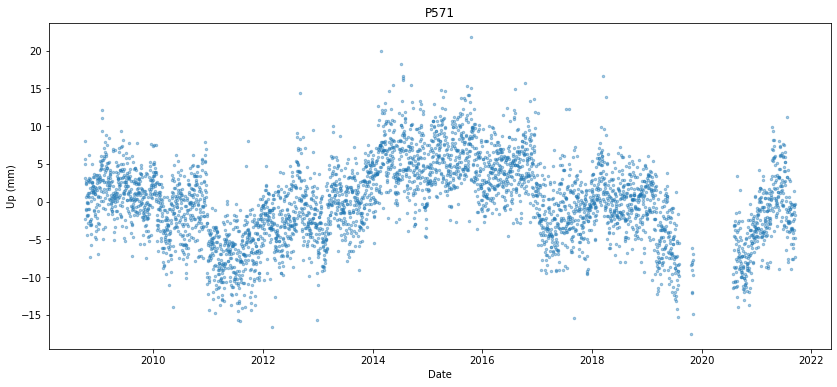

In [115]:
fig, ax = plt.subplots(figsize=(14, 6),sharex=True, sharey=True)
ax.scatter(p571.index, p571['hrem'], alpha=0.4, s=6)
ax.set_xlabel('Date')
ax.set_ylabel('Vertical (mm)')
ax.set_title('P571');

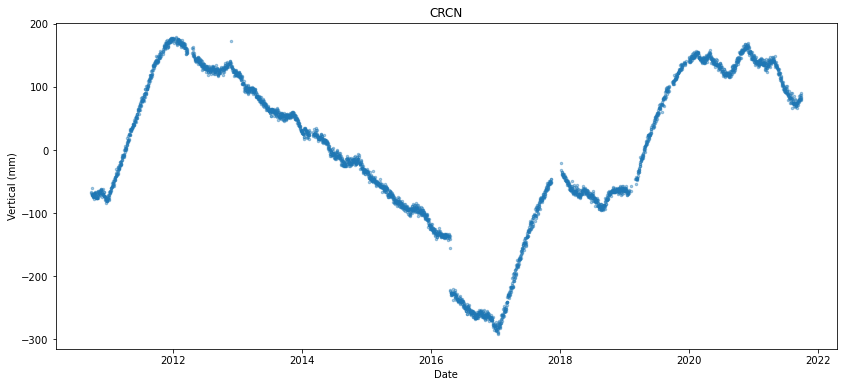

In [116]:
fig, ax = plt.subplots(figsize=(14, 6),sharex=True, sharey=True)
ax.scatter(crcn.index, crcn['hrem'], alpha=0.4, s=6)
ax.set_xlabel('Date')
ax.set_ylabel('Vertical (mm)')
ax.set_title('CRCN');

**Q25: What does this resulting signal represent?**

This is the seasonal removed signal. 

**Q26: For, P571 do you think this model is a good approximation of the annual and semi-annual signal? What about for CRCN?**

For P571 it seems to be a good-ish approximation of the seasonal signal. For CRCN, maybe this is not the best model. 

**Q27: Let's take a break from the fitting, removing and plotting cycle and scrape the basics of comparisons. Go ahead and check this link about drought in California: https://en.wikipedia.org/wiki/Droughts_in_California#/media/File:Drought_area_in_California.svg. Go ahead and compare the drought metric to the CRCN time series. Describe any patterns and correlations you see.** 

Ok, great break. Now back into it. The next part is a touch harder because I'm not going to give you the code to do this but instead I want to see how all of you might approach this. Use your creativity!

**Q28: You might have noticed that there are outliers in the time series. How might you remove these consistently from the time series? Feel free to chat with your neighbors or chat with us. Remember outliers are data points that differ signigicantly from other nearby observations.**

Basically you want to remove data points that are some amount away from a mean or median. So a good way to do this is data points some number of standard deviations away from a mean or median. Medians tend to be less sensitive to outliers so sometimes is preferred. Often a window is used for this. Here is one of many options of how to do this. 

Let's test it out. Go ahead and code this up and see how it performs. Tinker until it's not removing too much data and instead is just grabbing the outliers. Feel free to chat with your neighbors. If you're really stuck, just ask. But remember there are many ways to do the same thing so use your creativity! 

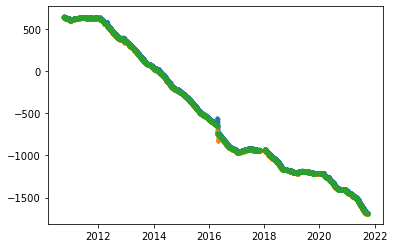

In [118]:
ab= crcn.vertical.rolling(14).std()
cd= crcn.vertical.rolling(14).median()

plt.plot(cd+2*ab, '.')
plt.plot(cd-2*ab, '.')
plt.plot(crcn.vertical, '.')

upperlim = cd+2*ab
lowerlim = cd-2*ab #anything above or below this limit you could remove

Alright, speedy coders. Lets dive deeper. We've discussed offsets in the time series and while these time series don't have any huge offsets you can check the UNR website and see that the reason I had you cut the time series to the dates I did was to avoid offsets. While this is one way to avoid offsets in the timeseries, another method is to estimate and correct the time series for the offsets. One way to do that is to include steps in the model we are using. This is typically done by adding a heaviside function in. A heaviside function is a simple step function (https://en.wikipedia.org/wiki/Heaviside_step_function). By doing this we can estimate the amplitude and direction of the offset. 

Here is the new model:

${y}(t_{i}) = {y}_{0} + {v}({t}_{i}) + {a}\sin(\omega{t}_{i}) + {b}\cos(\omega{t}_{i}) + {c}\sin(2\omega{t}_{i}) + {d}\cos(2\omega{t}_{i}) + \sum \limits_{j=1}^{{n}_{g}} {g}_{j} {H}({t}_{i} - {T}_{g})$

where H is the heaviside function, and the magnitude ${g}$ of ${n}_{g}$ offsets occuring at epoch ${T}_{g}$ are due to coseismic or non-coseismic offsets. 

Go ahead and add in the estimation of offsets into your model. Once you think you got your model working, extend your time series for XXX and see how it performs. 

Again, feel free to talk to your neighbors or to us. 


Does your code allow for a variable amount of offsets? Or just a single offset? If just a single offset, see if you can get it to handle a variable amount of offsets. 

A little more? Let's dive into post-seismic signals. After a large earthquake, the elastic deformation that accumulated continues to be released - for long periods after the main shock. This leads to something called post-seismic relaxation or post-seismic decay. If you want to learn more about post-seismic decay check out: https://academic.oup.com/gji/article/155/3/753/629085 or CITATION. 

This relaxation is generally most prominent in the horizontal components but also appears in the vertical component. Fitting the postseismic deformation can be tricky. Generally, it can be seperated into either afterslip (typically modeled with an exponential) or deformation occuring in the mantle (typically modeled with a log). Both are typically added onto the model with a heaviside function -- to account for any co-seismic offset that occurred. 

The exponential function is in the form of: 

$ \sum \limits_{j=1}^{{n}_{h}} {h}_{j} ({1}-{e}^{- \frac{{t}_{i} - {T}_{hj}} {{\tau}_{j}}}) {H}({t}_{i} - {T}_{hj})$

where the post seismic deformation that begins at the time of the earthquake ${T}_{hj}$ and ${\tau}_{j}$ is the time constant which changes based on the earthquake.  

And the log function is in the form of:

$ \sum \limits_{j=1}^{{n}_{k}} {k}_{j} \log ({1}+\frac{{t}_{i} - {T}_{kj}} {{\tau}_{j}}) {H}({t}_{i} - {T}_{kj})$


You can go head and try incorporate the one of these into the model. Again, this is only necessary for large earthquakes. If you want an example of a time series with a large post-seismic deformation you can check out stations AB13, PKDB, HOGS, LAND. 